# ETL Pipeline

## Imports

In [1]:
import logging

import matplotlib.pyplot as plt
import pandas as pd

from src.extract.imap.imap_extractor import IMAPExtractor
from src.extract.pst.pst_extractor import PSTExtractor
from src.models.topic_modelling import TopicModellor
from src.models.vectorizer import Vectorizer
from src.transform.message_transformer import get_language, get_response_time, clean_text, normalize_text
from src.models.message_classification import classify_messages

logging.basicConfig(level=logging.INFO)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/home/belalm/miniconda3/envs/qib/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
[nltk_data] Downloading package punkt to /home/belalm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/belalm/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/belalm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to

## Extraction

### Ingest from PST

In [2]:
pst_extractor = PSTExtractor("./data/raw/emails.pst")
pst_message_df = pst_extractor.message_df

INFO:root:Opening ./data/raw/emails.pst for extraction
INFO:root:Found 5039 messages in total
INFO:root:Parsing messages
INFO:root:Filling missing data
INFO:root:Parsing email threading
INFO:root:Parsing domain info
INFO:root:Extracting missing email ids
INFO:root:Extracted 5039 messages


Get missing emails.

In [3]:
missing_emails = pst_extractor.missing_email_ids
print(len(missing_emails))

739


### Ingest Missing Emails from IMAP Server

IMAP Server Setup

In [4]:
# EMAIL_ACCOUNT = ''
# PASSWORD = ''
# SERVER = 'imap.gmail.com'
# imap_extractor = IMAPExtractor(EMAIL_ACCOUNT, PASSWORD, SERVER)

Available Mailboxes

In [5]:
# imap_extractor.list_mailboxes()

Fetch Missing Emails

In [6]:
# mailboxes_to_fetch = ["INBOX", "\"[Gmail]/Sent Mail\""]
# imap_message_df = imap_extractor.extract_messages_from_imap(mailboxes_to_fetch, missing_emails, None)

Export to CSV

In [7]:
pst_message_df.to_csv("./data/interim/pst_emails.csv", index=False)
# imap_message_df.to_csv("./data/interim/imap_emails.csv", index=False)

Load from CSV

In [8]:
pst_message_df = pd.read_csv("./data/interim/pst_emails.csv")
# imap_message_df = pd.read_csv("./data/interim/imap_emails.csv")

## Transformations

### Preprocessing

Concatenate PST and IMAP Messages

In [9]:
# message_df = pd.concat([pst_message_df, imap_message_df], ignore_index=True)
message_df = pst_message_df

Clean Text

In [10]:
message_df['clean_text'] = message_df['plain_text_body'].apply(lambda x: clean_text(x))

Text Intended for NLP

In [11]:
message_df['normalized_text'] = message_df['clean_text'].apply(lambda x: normalize_text(x))

Response Times

In [12]:
message_df = get_response_time(message_df)

Language Detection

In [13]:
message_df["language"] = message_df["clean_text"].apply(get_language)

Sample and Export Preprocessed Messages

In [14]:
message_df.head(50).to_csv("./data/interim/sample_preprocessed_messages.csv")
message_df.head(10)

,message_id,subject,subject_prefix,submit_time,delivery_time,html_body,plain_text_body,from_name,from_address,to_address,...,first_in_thread,num_previous_messages,thread_id,sender_domain,all_domains,is_internal,clean_text,normalized_text,response_time,language
0,CANc0Yq66py_2t28pJ0H6E47s_BRZv1qR6O9=KFp2wqUC+...,Re: QSTP summer Workshops Program,re:,2024-06-30 05:06:15+00:00,2024-06-30 05:06:26+00:00,"<div dir=""ltr""><div dir=""auto""><b><font color=...","Reminder!\n\n \n\nOn Sat, 29 Jun 2024 at 6:06...",Mohammed Alsahal,m7mdalsahal@gmail.com,"20180065@ariu.edu.qa, 2862633102@qq.com, ahmed...",...,False,1.0,CANc0Yq7Oy8un7hjwvQsEJyum4-p905KNjfPscOpabNgtC...,gmail.com,"andrew.cmu.edu, ariu.edu.qa, ecommeta.uk, gmai...",False,Reminder!,remind,None,en
1,1f230c7e1de149559e2814218dfa5b53@ubc-csm.sympl...,"Belal, the latest ""All Opportunities"" jobs are...",NaN,2024-06-30 06:14:35+00:00,2024-06-30 06:14:38+00:00,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","| | \n--- \n \n Belal, here are your lat...",csic.careersonline@ubc.ca,csic.careersonline@ubc.ca,belal.mnur@gmail.com,...,True,NaN,NaN,ubc.ca,"gmail.com, ubc.ca",False,"| | \n--- \n Belal, here are your latest ...",belal latest job match miss match opportun job...,None,en
2,ff49f537-ed2d-5429-9079-70350a2e4b6a@mail.uber...,Your Sunday morning trip with Uber,NaN,2024-06-30 06:36:18+00:00,2024-06-30 06:36:20+00:00,"<!doctype html><html><head><meta charset=""utf-...",| | | | | | | | | | | | | | | | | | Total QA...,Uber Receipts,noreply@uber.com,belal.mnur@gmail.com,...,True,NaN,NaN,uber.com,"gmail.com, uber.com",False,| | | | | | | | | | | | | | | | | | Total QA...,total qar thank ride belal hope enjoy ride mor...,None,en
3,15.96.04233.1FCF0866@ccg01mail06,Your payment to Uber BV has been processed,NaN,2024-06-30 06:36:33+00:00,2024-06-30 06:36:34+00:00,"<html dir=""ltr"" lang=""en"">\n\n <head>\n <m...","#### Belal Mohammed-Nur, payment has been proc...",service@intl.paypal.com,service@intl.paypal.com,belal.mnur@gmail.com,...,True,NaN,NaN,intl.paypal.com,"gmail.com, intl.paypal.com",False,"#### Belal Mohammed-Nur, payment has been proc...",belal payment process hello belal payment proc...,None,en
4,99b24ce1-7f39-5615-a5ad-15e0b3a95b03@mail.uber...,Your Sunday afternoon trip with Uber,NaN,2024-06-30 10:39:06+00:00,2024-06-30 10:39:08+00:00,"<!doctype html><html><head><meta charset=""utf-...",| | | | | | | | | | | | | | | | | | Total QA...,Uber Receipts,noreply@uber.com,belal.mnur@gmail.com,...,True,NaN,NaN,uber.com,"gmail.com, uber.com",False,| | | | | | | | | | | | | | | | | | Total QA...,total qar thank ride belal hope enjoy ride aft...,None,en
5,23.86.04509.2D531866@ccg01mail05,Your payment to Uber BV has been processed,NaN,2024-06-30 10:39:14+00:00,2024-06-30 10:39:15+00:00,"<html dir=""ltr"" lang=""en"">\n\n <head>\n <m...","#### Belal Mohammed-Nur, payment has been proc...",service@intl.paypal.com,service@intl.paypal.com,belal.mnur@gmail.com,...,True,NaN,NaN,intl.paypal.com,"gmail.com, intl.paypal.com",False,"#### Belal Mohammed-Nur, payment has been proc...",belal payment process hello belal payment proc...,None,en
6,0100019069db219e-5ca01c62-bf2e-450f-8d6f-6b478...,Next stop? Deals.,NaN,2024-06-30 15:54:47+00:00,2024-06-30 15:54:48+00:00,"<!doctype html><html lang=""en"" dir=""auto"" xmln...",Get excited. Deals are coming.͏ ‌ ­͏ ‌ ­͏ ...,Amazon.ca,store-news@amazon.ca,belal.mnur@gmail.com,...,True,NaN,NaN,amazon.ca,"amazon.ca, gmail.com",False,Get excited. Deals are coming.͏ ‌ ­͏ ‌ ­͏ ...,get excit deal today deal best seller buy huge...,None,am
7,50b8f163-658c-5ac1-88c6-1b287f8ac70a@mail.uber...,Your Monday morning trip with Uber,NaN,2024-07-01 08:43:55+00:00,2024-07-01 08:43:57+00:00,"<!doctype html><html><head><meta charset=""utf-...",| | | | | | | | | | | | | | | | | | Total QA...,Uber Receipts,noreply@uber.com,belal.mnur@gmail.com,...,True,NaN,NaN,uber.com,"gmail.com, uber.com",False,| | | | | | | | | | | | | | | | | | Total QA...,total qar thank ride belal hope

In [15]:
message_df.to_csv("./data/interim/preprocessed_messages.csv")

### Feature Engineering and Modelling

#### Vectorization of Emails

Vectorization - Sentence Embeddings

In [16]:
vectorizer = Vectorizer(message_df)
sentence_embeddings = vectorizer.create_sentence_embeddings()

Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Adding Vectors to Chroma

In [17]:
# vectorizer.append_to_chroma("tfidf", tfidf_embeddings)
# vectorizer.append_to_chroma("messages", sentence_embeddings)

#### Intent Analysis 

In [18]:
intent_analyzer = TopicModellor(message_df)
message_df = intent_analyzer.cluster_topics(sentence_embeddings)

In [21]:
unigram_frequencies, bigram_frequencies, trigram_frequencies = intent_analyzer.get_word_frequencies()

ValueError: empty vocabulary; perhaps the documents only contain stop words

Top 10 Clusters and Their Sizes

In [ ]:
bigram_frequencies.loc[bigram_frequencies['topic_id'] != -1]['topic_id'].value_counts().head(10)

cluster
11    4781
51    2664
49    2598
48    2512
21    2335
78    2199
54    1680
29    1591
53    1432
64    1372
Name: count, dtype: int64

Get the Descriptions for Each Topic

In [ ]:
cluster_descriptions = intent_analyzer.get_cluster_descriptions()
cluster_descriptions.head(10)

,cluster,description
0,4,"This is an email notification from OverDrive, ..."
1,20,Announcements and updates about the Open Sourc...
2,34,Website upgrade and promotional offers.
3,42,Promotions and sales of designer home furnishi...
4,1,It seems you forgot to provide the email sampl...
5,49,Notifications and updates from Sketchfab.
6,44,Updates to Photon Unity Networking software.
7,21,This is a well-designed and informative newsle...
8,43,Interior design and 3D model resources.
9,45,Unity Asset Store updates and notifications.


Showcase Word Cloud per Cluster

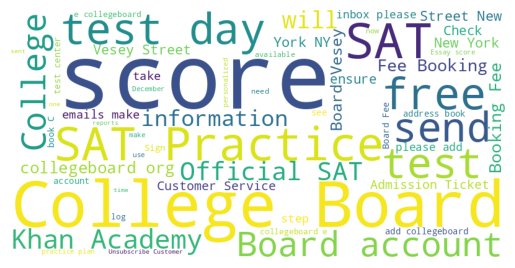

In [ ]:
plt.axis("off")
plt.imshow(intent_analyzer.generate_word_cloud(77))

Export to CSV

In [ ]:
message_df.to_csv("./data/processed/messages.csv", index=False)

#### Sentiment Analysis and Trajectory Within Threads

#### Message Classification

In [ ]:
message_df = classify_messages(message_df)

## Analysis

### Top Word Analysis